# Single Molecule Event classification

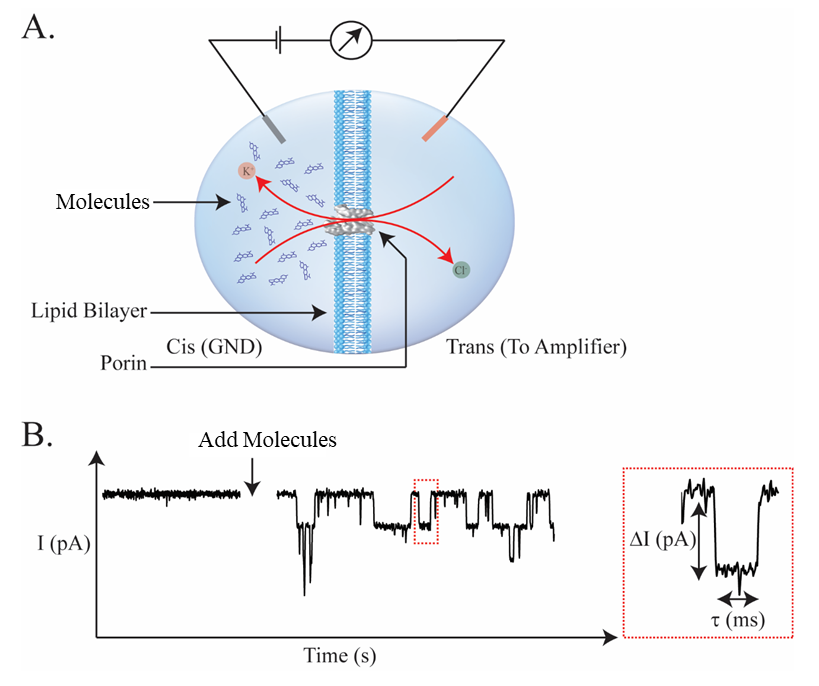

In [92]:
from IPython import display
display.Image("NanoporeCartoon.PNG",width= 500, height=500)

#### A. Schem of experimental setup
#### B. Event charateristic and different folding stages of molecule 

# ___________________________________

#### Example of some of the different folding states

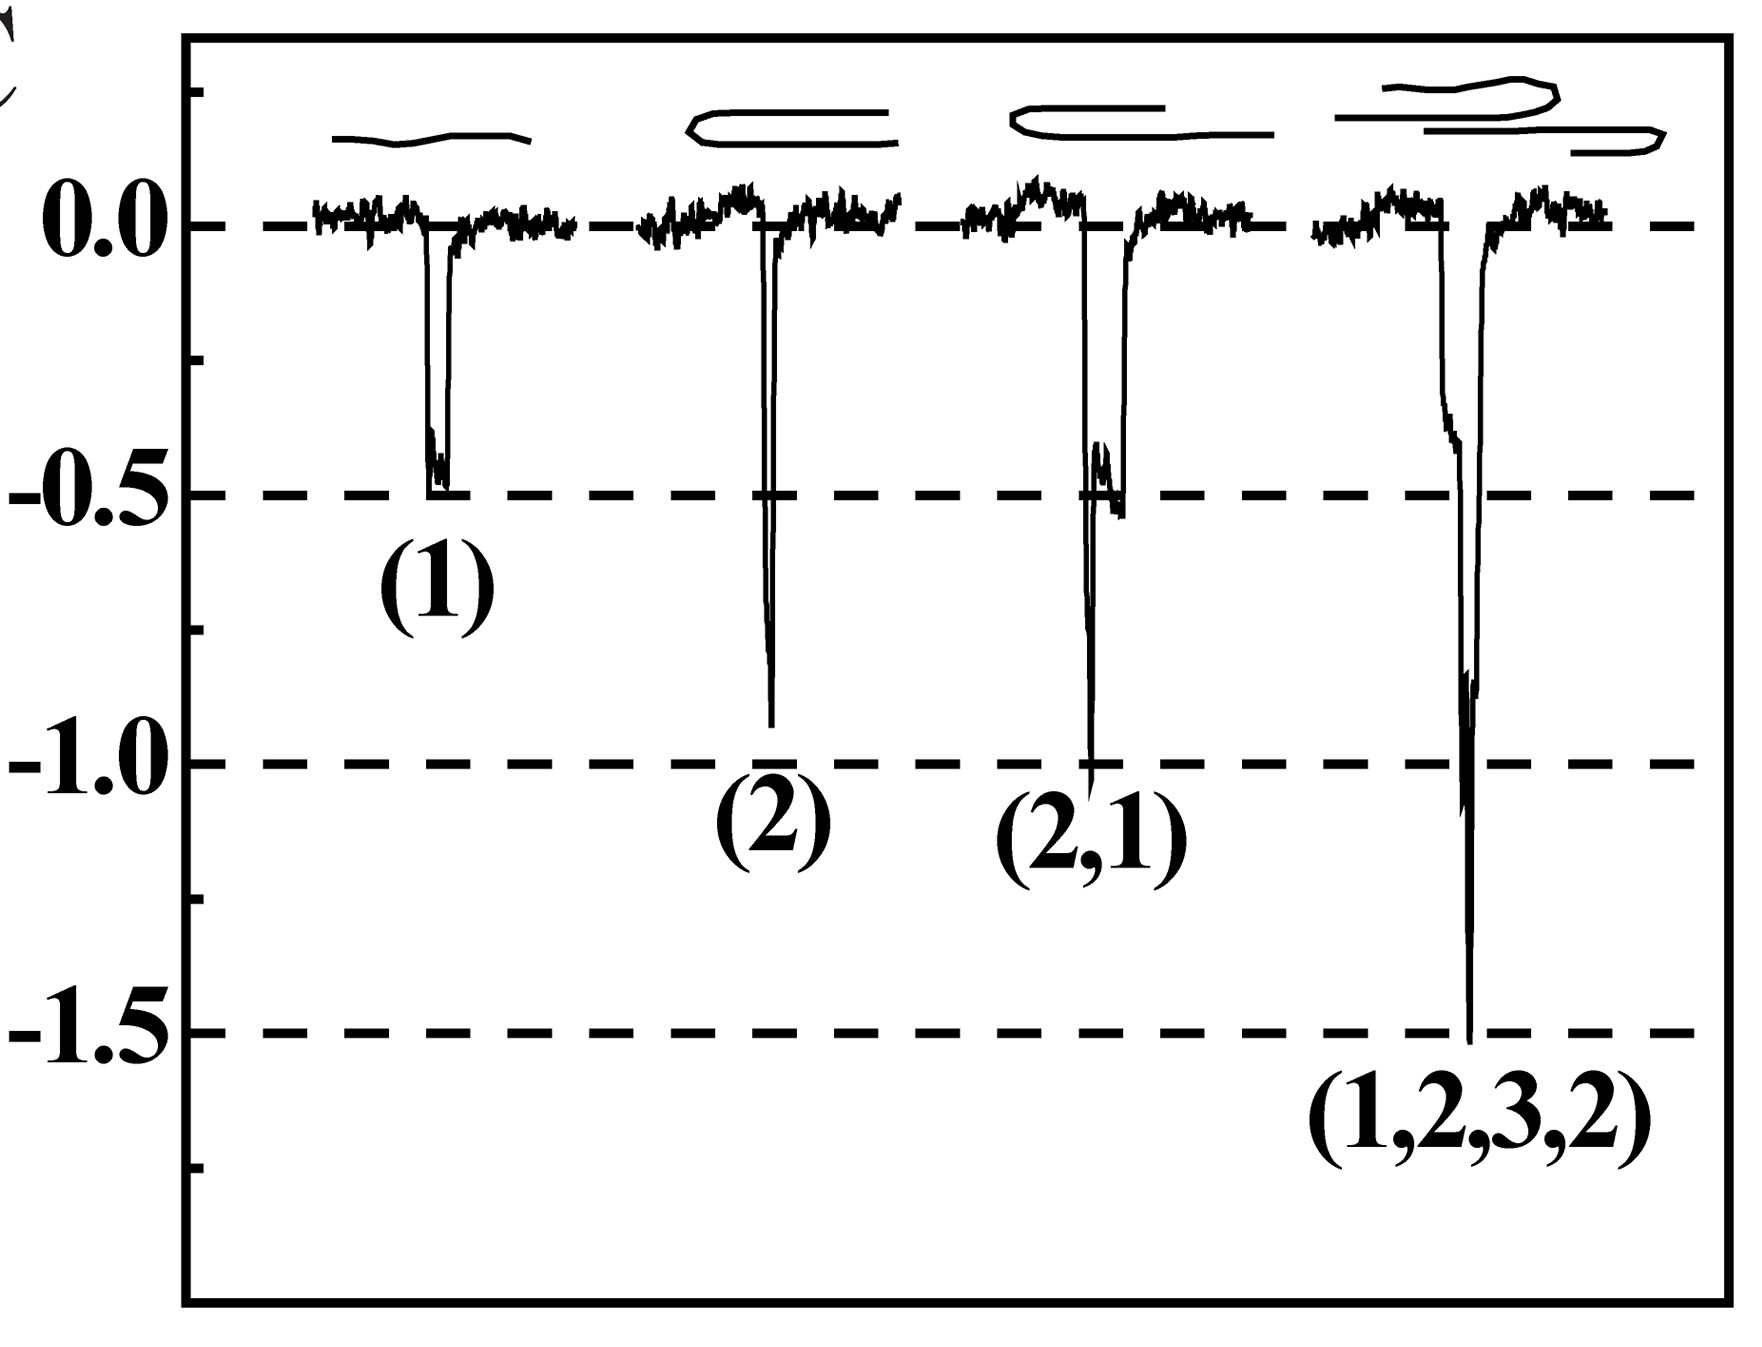

In [93]:
display.Image("EventType.JPG",width= 500, height=500)

# 1. Importing necessary libraries

In [1]:
#importing basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
import multiprocessing

# models
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from catboost import CatBoostClassifier


from dask.distributed import Client
# It's recommended to use dask_cuda for GPU assignment
from dask_cuda import LocalCUDACluster
from dask import array as da
import xgboost as xgb
import dask

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
# to visualize the column transformer and pipeline
set_config(display='diagram')

# 2. Importing the data

In [2]:
df = pd.read_csv('C://Users//Asus//OneDrive//Desktop//Jayesh_ML//Single_Molecule_Event_Classification//Data_set/DataSet_Kan_100mV_set2.csv',low_memory=False )
df.head() 

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms)
0,1,1,1,AB,0.22,0.26,36.300587,0.000000,0.04,NaN,Not found
1,1,1,0,A,0.26,1.50,1.740591,5.838978,1.24,NaN,Not found
2,1,1,1,AB,1.50,1.56,9.592655,0.000000,0.06,781.250000,1.279999971
3,1,1,0,A,1.56,3.42,0.673338,6.202096,1.86,769.230774,1.299999952
4,1,1,1,AB,3.42,3.46,49.259743,0.000000,0.04,520.833313,1.919999957


# 3. Data Wrangling and EDA

In [3]:
#quick way to check the datatypes and if the dataframe has any null val
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225830 entries, 0 to 225829
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trace                        225830 non-null  int64  
 1   Search                       225830 non-null  int64  
 2   Level                        225830 non-null  int64  
 3   State                        225830 non-null  object 
 4   Event Start Time (ms)        225830 non-null  float64
 5   Event End Time (ms)          225830 non-null  float64
 6   Amplitude (pA)               225830 non-null  float64
 7   Amp S.D. (pA)                225830 non-null  float64
 8   Dwell Time (ms)              225830 non-null  float64
 9   Peak-to-Peak Frequency (Hz)  225825 non-null  float64
 10  Interevent Interval (ms)     225830 non-null  object 
dtypes: float64(6), int64(3), object(2)
memory usage: 19.0+ MB


In [4]:
# checking any null val in the dataframe
df.isna().sum()

Trace                          0
Search                         0
Level                          0
State                          0
Event Start Time (ms)          0
Event End Time (ms)            0
Amplitude (pA)                 0
Amp S.D. (pA)                  0
Dwell Time (ms)                0
Peak-to-Peak Frequency (Hz)    5
Interevent Interval (ms)       0
dtype: int64

In [5]:
# checking the shape/ size of a dataframe
df.shape

(225830, 11)

In [6]:
# Removing null vales from the dataset
df.dropna(subset = ["Peak-to-Peak Frequency (Hz)"], inplace=True)

# transforming the datatype from object to numeric
df['Interevent Interval (ms)'] = pd.to_numeric(df['Interevent Interval (ms)'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 225825 entries, 2 to 225829
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Trace                        225825 non-null  int64  
 1   Search                       225825 non-null  int64  
 2   Level                        225825 non-null  int64  
 3   State                        225825 non-null  object 
 4   Event Start Time (ms)        225825 non-null  float64
 5   Event End Time (ms)          225825 non-null  float64
 6   Amplitude (pA)               225825 non-null  float64
 7   Amp S.D. (pA)                225825 non-null  float64
 8   Dwell Time (ms)              225825 non-null  float64
 9   Peak-to-Peak Frequency (Hz)  225825 non-null  float64
 10  Interevent Interval (ms)     225825 non-null  float64
dtypes: float64(7), int64(3), object(1)
memory usage: 20.7+ MB


In [8]:
#df.head()

In [9]:
df.columns

Index(['Trace', 'Search', 'Level', 'State', 'Event Start Time (ms)',
       'Event End Time (ms)', 'Amplitude (pA)', 'Amp S.D. (pA)',
       'Dwell Time (ms)', 'Peak-to-Peak Frequency (Hz)',
       'Interevent Interval (ms)'],
      dtype='object')

## 3.1 Data Visualization

### 3.3.1 Scatter plot of Amplitude versus Dwell Time, Interevent Time and Peat-Peak Frequency

####################################################################################################

Scatter plot of all the numeric features

####################################################################################################


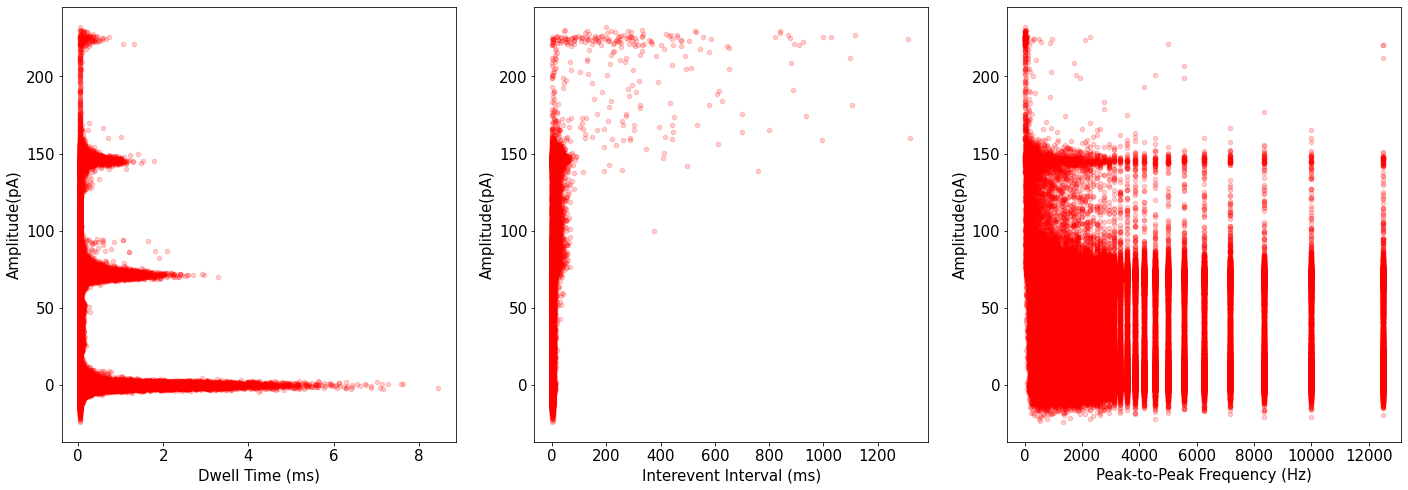

In [10]:
# Cosmetics
print('#'*100)
print()
print('Scatter plot of all the numeric features')
print()
print('#'*100)

features = ['Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)']

# Figure cosmetics
fig, axs = plt.subplots(1,len(features), figsize=(24,8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)

# looping through all the feature 
for f, i in zip(features, range(len(features))):
    
    axs[i].scatter(df[f],df['Amplitude (pA)'], s =20, c = 'r', alpha = 0.2)
    axs[i].set_xlabel(f,fontsize=15)
    axs[i].set_ylabel('Amplitude(pA)',fontsize=15)
    axs[i].tick_params(axis='x', labelsize= 15)
    axs[i].tick_params(axis='y', labelsize= 15)

### 3.1.2 Histogram of all the important numeric features

####################################################################################################

Histogram of all the important numeric features

####################################################################################################


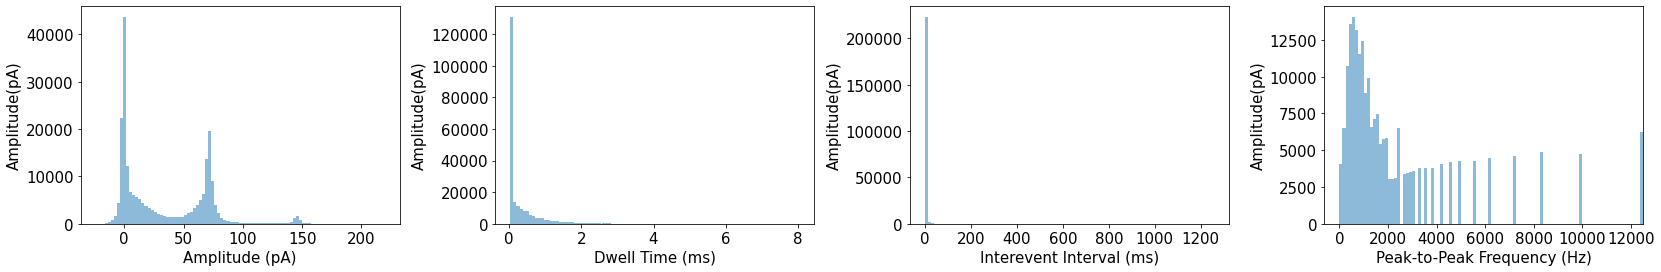

In [11]:
# Cosmetics
print('#'*100)
print()
print('Histogram of all the important numeric features')
print()
print('#'*100)

features = ['Amplitude (pA)','Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)']

# Figure cosmetics
fig, axs = plt.subplots(1,len(features), figsize=(28,4), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.3)

# looping through all the feature 
for f, i in zip(features, range(len(features))):
    
    axs[i].hist(df[f], bins = 100, alpha = 0.5)
    axs[i].set_xlim(df[f].min() - (df[f].max()-df[f].min())/20,df[f].max())
    axs[i].set_xlabel(f,fontsize=15)
    axs[i].set_ylabel('Amplitude(pA)',fontsize=15)
    axs[i].tick_params(axis='x', labelsize= 15)
    axs[i].tick_params(axis='y', labelsize= 15)
    

### 3.1.3 Boxplot of all the numeric features to visualize outliers

####################################################################################################

BoxPlot of all the numeric features

####################################################################################################


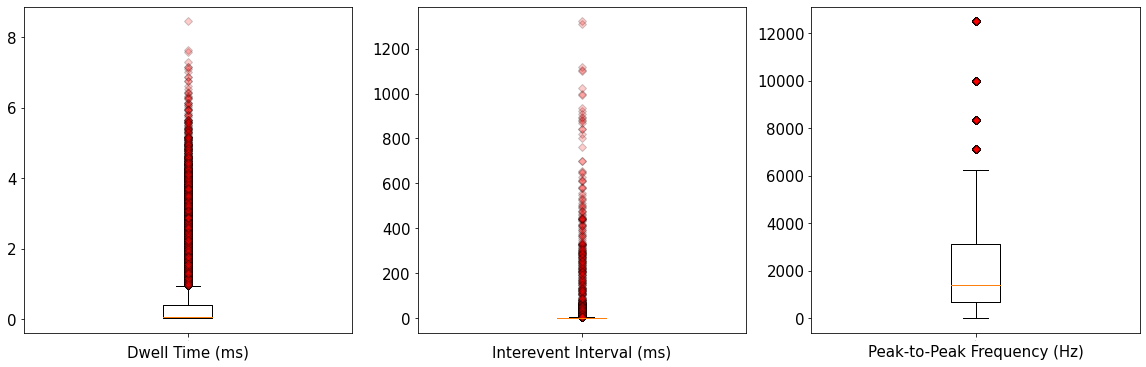

In [12]:

print('#'*100)
print()
print('BoxPlot of all the numeric features')
print()
print('#'*100)

features = features = ['Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)']

# Figure cosmetics
fig, axs = plt.subplots(1,len(features), figsize=(20,6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.2)
green_diamond = dict(markerfacecolor='r', marker='D', alpha = 0.2)

# looping through all the feature 
for f, i in zip(features, range(len(features))):
    axs[i].boxplot(df[f],flierprops=green_diamond, labels = None)
    axs[i].set_xlabel(f,fontsize=15)
    axs[i].tick_params(axis='x', labelsize= 0) 
    axs[i].tick_params(axis='y', labelsize= 15)

In [13]:
df.head(1)

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms)
2,1,1,1,AB,1.5,1.56,9.592655,0.0,0.06,781.25,1.28


# 4. Feature Engineering

## ECD calculation of single events (Electron Charge Deficit calc):

 $$ ecd = \int_{0}^{D_T} \Delta I_{B}(t)dt$$
 $$ $$
        $$=  \Delta I_{avg}.T_{R} $$
        
  
 $$ ecd  = Electron Charge Deficit $$
 $$ {D_T} = Dwell Time $$
 $$ I_{B} = Blockage Current $$

In [14]:
df['ECD'] = df['Amplitude (pA)']*df['Dwell Time (ms)'] #calculating ECD 

In [15]:
df.head(2)

,Trace,Search,Level,State,Event Start Time (ms),Event End Time (ms),Amplitude (pA),Amp S.D. (pA),Dwell Time (ms),Peak-to-Peak Frequency (Hz),Interevent Interval (ms),ECD
2,1,1,1,AB,1.50,1.56,9.592655,0.000000,0.06,781.250000,1.28,0.575559
3,1,1,0,A,1.56,3.42,0.673338,6.202096,1.86,769.230774,1.30,1.252409


In [16]:
#df.info()

<AxesSubplot:xlabel='Level', ylabel='count'>

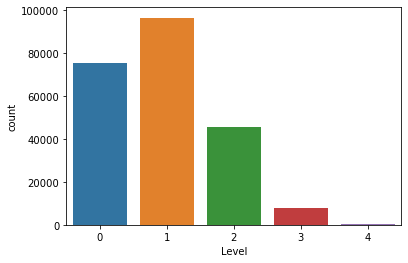

In [17]:
sns.countplot(data = df, x  =df['Level']) #visualizing target variable using countplot 

### Looking at the above barplot of 'Levels,' which is the dataset's taget variable, it appears that the dataset has an imbalance class, which would generate a bias while developing the model by shadowing the minor class (level 3 and level 4). To solve this issue, I will approach this dataset in 4 steps:

#### 1. During the first stage of model development and metric evaluation, I will use the data as is.

#### 2. Following that, I will eliminate levels 3 and 4, construct the model, and compare their metrics.

#### 3. Next, I'll restore all of the feature and use inbult libraries to correct for data imbalance.

#### 4. Finally, I'll check feature importance from the best model and reconstruct the model with the important features and evaluate further with hyperparameter tuning

# 5. Spliting the data

In [19]:
df.columns 

Index(['Trace', 'Search', 'Level', 'State', 'Event Start Time (ms)',
       'Event End Time (ms)', 'Amplitude (pA)', 'Amp S.D. (pA)',
       'Dwell Time (ms)', 'Peak-to-Peak Frequency (Hz)',
       'Interevent Interval (ms)', 'ECD'],
      dtype='object')

In [20]:
# spliting data into dependent variable (X) and independent variable (y) 
X = df[['Amplitude (pA)','Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']]

y = df['Level']

# 6. Train - Test Split

In [21]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state= 42)
#Xtrain, Xtest, ytrain, ytest

In [22]:
# Select Categorical and numeric features
#categorical_col = Xtrain.select_dtypes(include='object').columns # not categorial columns in the dataframe
numeric_col = Xtrain.select_dtypes(include='number').columns

In [23]:
numeric_col

Index(['Amplitude (pA)', 'Dwell Time (ms)', 'Interevent Interval (ms)',
       'Peak-to-Peak Frequency (Hz)', 'ECD'],
      dtype='object')

# 7. Scaling and Transforming the data

In [24]:
# Instantiate the function OneHotEncode
ohe = OneHotEncoder()

In [25]:
# Instantiate the function RobustScaler
scaler = RobustScaler()
scaler_min_max = MinMaxScaler()
Scaler_standard = StandardScaler()

In [26]:
# Define transformers
transformers = [
                ('Scaler_standard', StandardScaler(), numeric_col)]

#('ohe', OneHotEncoder(drop='first'), categorical_col)

In [27]:
# Define column transformer
column_transformer = ColumnTransformer(
    transformers=transformers, remainder='drop')

In [28]:
# Fit and transform the column transformer ONLY on Xtrain
Xtrain_tf = column_transformer.fit_transform(Xtrain)

# Transform Xtest
Xtest_tf = column_transformer.transform(Xtest)

In [29]:
column_transformer

ColumnTransformer(transformers=[('Scaler_standard', StandardScaler(),
                                 Index(['Amplitude (pA)', 'Dwell Time (ms)', 'Interevent Interval (ms)',
       'Peak-to-Peak Frequency (Hz)', 'ECD'],
      dtype='object'))])

In [30]:
# changes in col names
Xtrain_tf = pd.DataFrame(Xtrain_tf, columns=['Amplitude_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtrain_tf

In [31]:
# changes in col names
Xtest_tf = pd.DataFrame(Xtest_tf, columns=['Amplitude_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtest_tf

# 8. Train Model


In [32]:
target_names = ['Level 0','Level 1', 'Level 2','Level 3','Level 4']

In [33]:
# Building an ensemble which will train data on range of classification model:
def ensemble_models(xtraining, ytraining, xtesting,ytesting,target_names):
    
    """This function evaluates multiple classifier models on a given dataset 
        and generates a evaluation report for all the models and based on that, one 
        can choose best model for further optimizing the model
        *******************************************************************************
        Inputs required:
            1. xtraining
            2. xtesting
            3. ytraining
            4. ytesting
            5. target_name : this is input list with all the target names
                eg: target_name = ['Level 0','Level 1', 'Level 2','Level 3','Level 4']
        *******************************************************************************        
        Output:
            1. Classification report
                eg:     precision    recall  f1-score   support

             Level 0       1.00      0.93      0.96     18753
             Level 1       0.85      0.99      0.91     24273
             Level 2       0.96      0.76      0.84     11399
             Level 3       0.90      0.83      0.86      1960
             Level 4       0.83      0.90      0.87        72

            accuracy                           0.92     56457
           macro avg       0.91      0.88      0.89     56457
        weighted avg       0.92      0.92      0.91     56457
        
            2. Dataframe with crossvalidate score value for all the models
            3. Box plot of Validation scores
        """
    models = [] #paired values in list
    models.append(('LR', LogisticRegression(solver='newton-cg', multi_class='ovr', n_jobs= -1 )))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('QDA',QuadraticDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier(n_jobs=-1)))
    #models.append(('CART', DecisionTreeClassifier()))
    models.append(('XGB',xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')))
    #models.append(('CatBC',CatBoostClassifier(task_type="GPU")))
    models.append(('RFC',RandomForestClassifier(n_jobs=-1)))
    models.append(('NB', GaussianNB()))

    # building a font dict so that it can be used for plotting boxplot
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }

    #scoring = precision_macro, recall_macro, accuracy, f1_macro, precision_micro

    #evaluate each model in turn:
    results = []
    names = []
    scores = pd.DataFrame()
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
        cv_results = cross_val_score(model, xtraining, ytraining, cv=kfold, scoring='accuracy')
        clf = model.fit(xtraining, ytraining)
        yprediction = clf.predict(xtesting)
        results.append(cv_results)
        names.append(name)

        print('#'*30)
        print(type(model).__name__)
        print()
        print(classification_report(ytesting, yprediction, target_names=target_names))
        #stat = {'val_score':round(cv_results.mean()*100,1), 'val_std':round(cv_results.std()*100,2)}
        #print(f'{name}:',round(cv_results.mean()*100,1),"\u00B1",round(cv_results.std()*100,2),'%')
        score = {'Validation_Score':round(cv_results.mean()*100,1), 'error':round(cv_results.std()*100,2)}
        scores = scores.append(score,ignore_index = True)
    #scores['model'] = names
    #scores.set_index('model', inplace=True)
    scores.insert(0, 'model', names) # here '0' is the column positioning in the dataframe
    print('#'*30)
    print()
    scores.sort_values(by=['Validation_Score'],ascending=False, inplace=True)
    print(scores)
    print()
    print(f'The best perfoming model based on accuracy is {scores.model.iloc[0]} with Validation_Score: {scores.Validation_Score.iloc[0]} \u00B1 {scores.error.iloc[0]}%')

    plt.boxplot(results, labels=names)
    plt.title('Algorithm comparison', fontdict=font)
    plt.xlabel('Models', fontdict=font)
    plt.ylabel('Validation_score', fontdict=font)
    plt.xticks(fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.show()
        
    

##############################
LogisticRegression

              precision    recall  f1-score   support

     Level 0       1.00      0.93      0.96     18753
     Level 1       0.85      0.99      0.92     24273
     Level 2       0.95      0.75      0.84     11399
     Level 3       0.91      0.68      0.78      1960
     Level 4       1.00      0.72      0.84        72

    accuracy                           0.91     56457
   macro avg       0.94      0.82      0.87     56457
weighted avg       0.92      0.91      0.91     56457

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     Level 0       0.94      0.89      0.91     18753
     Level 1       0.82      0.90      0.86     24273
     Level 2       0.85      0.75      0.80     11399
     Level 3       0.90      0.78      0.83      1960
     Level 4       1.00      0.67      0.80        72

    accuracy                           0.87     56457
   macro avg       0.

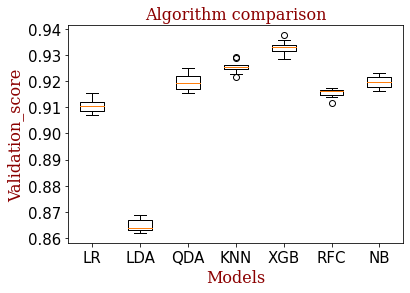

Wall time: 1min 32s


In [34]:
%%time
ensemble_models(Xtrain_tf,ytrain,Xtest_tf,ytest,target_names)

### By looking at the classification report and accuracy scores, I choose to work with XGBoostclassifier as it perfomed well compared to other models.

In [35]:
# Make prediction on validated dataset
model = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')
model.fit(Xtrain_tf, ytrain)
prediction = model.predict(Xtest_tf)

In [36]:
# confusion matrix with heatmap
def Confusion_Matrix_ (Test, Predicted, Class, model):
    
    """This function will generate a confusion matrix heat map with and without normalized count.
        The function will take 3 input arguments:
        1. Test: can be ytest or ytrain
        2. Predicted: can be ytest_predictes or ytrain_predicted
        3. Class: this is the list/vector of ytrain or ytest, it is just used 
            to automate the xtick and ytick labels
        4. model: str input of the model used
            eg: 'LR' for Logistic Regression."""
    #from matplotlib.pyplot import subplots, show
    
    fig, axs = plt.subplots(1,2, figsize=(24,8), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .1, wspace=.2)
    Normalize = [None,'true']
    sns.set(font_scale=2)
    for norm, i in zip(Normalize, range(len(Normalize))):
        corr_map = confusion_matrix(Test, Predicted, normalize=norm)
        sns.heatmap(corr_map,
                    annot=True,
                    cmap='BuPu',
                    ax=axs[i],
                    annot_kws={"size":20}
                    )
        
        axs[i].set_ylabel("True class",fontsize=25)
        axs[i].set_xlabel("Predicted class",fontsize=25)
        axs[i].set_title(f'Confusion_Martix - {model}',fontsize=20)
        axs[i].set_xticklabels(np.unique(Class),fontsize=20)
        axs[i].set_yticklabels(np.unique(Class),fontsize=20)
    return plt.show()

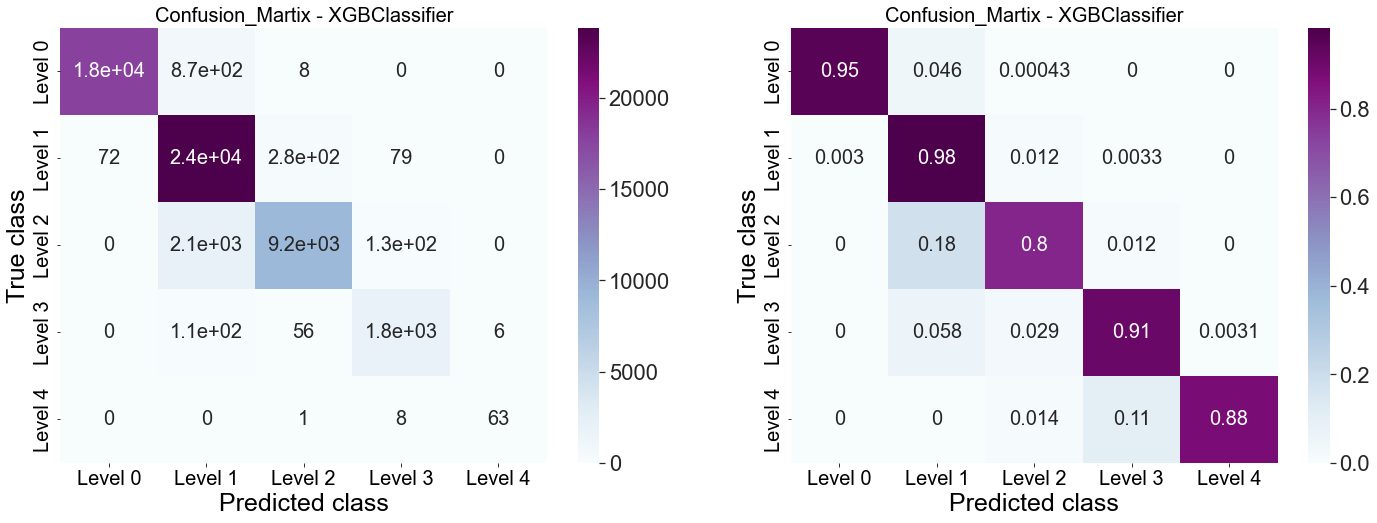

In [37]:
Confusion_Matrix_(ytest, prediction,target_names,'XGBClassifier')

### This will not work well for the above imbalanced dataset as the performance on the majority class will overshadow the minority class.

# _____________________________________________________________

### Drop level 3 and level 4 from the dataset and compare the evaluation metric before and after the drop to see if the model shows any bias towards majority class

In [38]:
df_model_1 = df.copy(deep=True)

In [39]:
df_model_1.drop(df_model_1[df_model_1['Level'] == 3].index, inplace = True)
df_model_1.drop(df_model_1[df_model_1['Level'] == 4].index, inplace = True)

In [40]:
df_model_1.shape

(217775, 12)

In [41]:

X_model_1 = df_model_1[['Amplitude (pA)','Dwell Time (ms)','Interevent Interval (ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']]

y_model_1 = df_model_1['Level']

In [42]:
Xtrain_, Xtest_, ytrain_, ytest_ = train_test_split(X_model_1, y_model_1, test_size=0.25, random_state= 42)

In [43]:
# Fit and transform the column transformer ONLY on Xtrain
Xtrain_model1_tf = column_transformer.fit_transform(Xtrain_)

# Transform Xtest
Xtest_model1_tf = column_transformer.transform(Xtest_)

In [44]:
Xtrain_model1_tf = pd.DataFrame(Xtrain_model1_tf, columns=['Amplitude_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtrain_tf    

Xtest_model1_tf = pd.DataFrame(Xtest_model1_tf, columns=['Amplitude_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtest_tf


In [45]:
target_names_model1 = ['class 0','class 1', 'class 2']

##############################
LogisticRegression

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     18841
     class 1       0.87      0.98      0.92     24110
     class 2       0.96      0.80      0.87     11493

    accuracy                           0.93     54444
   macro avg       0.94      0.90      0.92     54444
weighted avg       0.93      0.93      0.92     54444

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     class 0       0.93      0.90      0.91     18841
     class 1       0.81      0.92      0.87     24110
     class 2       0.93      0.73      0.82     11493

    accuracy                           0.87     54444
   macro avg       0.89      0.85      0.87     54444
weighted avg       0.88      0.87      0.87     54444

##############################
QuadraticDiscriminantAnalysis

              precision    recall  f1-score   support

     class 

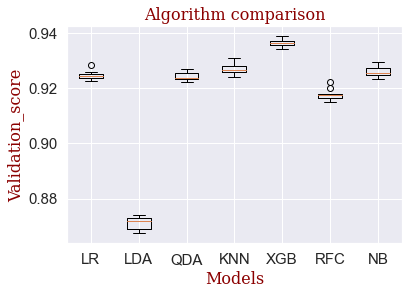

Wall time: 1min 13s


In [46]:
%%time
ensemble_models(Xtrain_model1_tf,ytrain_,Xtest_model1_tf,ytest_,target_names_model1)

In [47]:
# Make prediction on validated dataset
model_1 = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')
model_1.fit(Xtrain_model1_tf,ytrain_)
prediction_ = model_1.predict(Xtest_model1_tf)

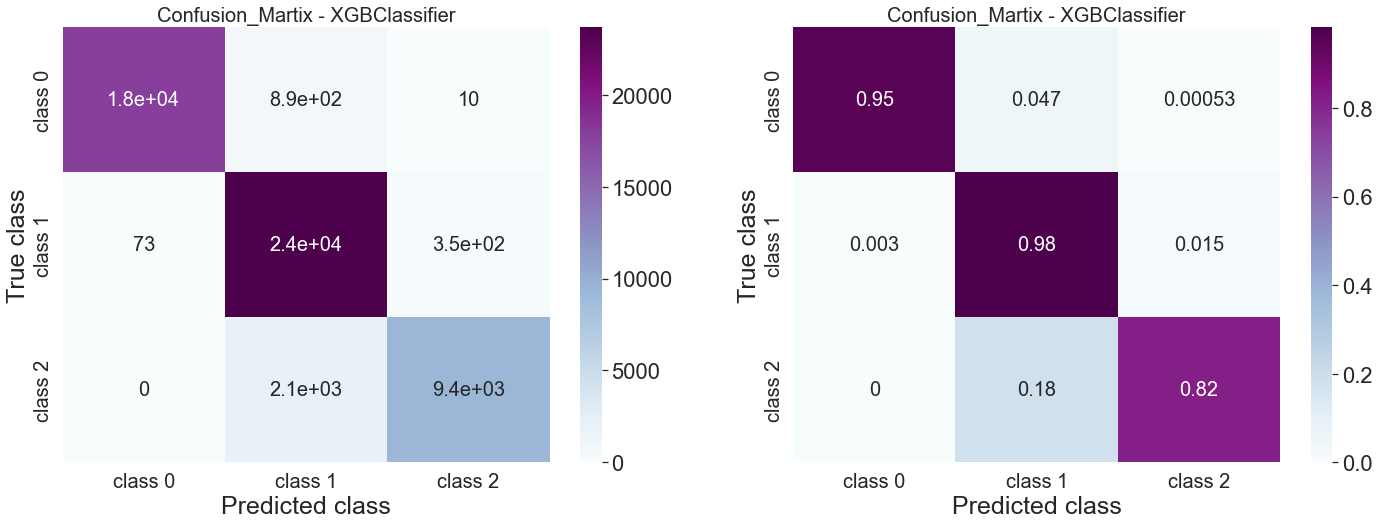

In [48]:
Confusion_Matrix_(ytest_, prediction_, target_names_model1,'XGBClassifier')

### Looking at the above report it seems that the model did not show any improveemt in the accuracy score after removing level 3 and level 4 .

# _______________________________________________________________

### 8.1 Correction to imbalance data

In [49]:
# Will oversample the data using random oversampler
ros = RandomOverSampler(random_state=10, sampling_strategy="auto")
X_ros, y_ros = ros.fit_resample(X, y)
print(f'unique samples in each class (oversampled): \n{y_ros.value_counts()}')

unique samples in each class (oversampled): 
1    96613
0    96613
2    96613
3    96613
4    96613
Name: Level, dtype: int64


In [50]:
Xtrain_ros, Xtest_ros, ytrain_ros, ytest_ros = train_test_split(X_ros, y_ros, test_size=0.25, random_state= 42)

In [51]:
# Fit and transform the column transformer ONLY on Xtrain
Xtrain_ros_tf = column_transformer.fit_transform(Xtrain_ros)

# Transform Xtest
Xtest_ros_tf = column_transformer.transform(Xtest_ros)

In [52]:
Xtrain_ros_tf = pd.DataFrame(Xtrain_ros_tf, columns=['Amplitude_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtrain_tf #'Amp_SD_(pA)',
Xtest_ros_tf = pd.DataFrame(Xtest_ros_tf, columns=['Amplitude_(pA)','Dwell_Time_(ms)','Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)', 'ECD']) #columns=column_transformer.get_feature_names_out()) the .get_feature_names_out() present only in sklear 1.0
#Xtest_tf #'Amp_SD_(pA)',

In [53]:
target_names_ros = ['class 0','class 1', 'class 2','class 3','class 4']

##############################
LogisticRegression

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     24319
     class 1       0.75      0.97      0.85     24105
     class 2       0.88      0.69      0.77     24087
     class 3       0.83      0.86      0.84     24025
     class 4       0.98      0.95      0.97     24231

    accuracy                           0.88    120767
   macro avg       0.89      0.88      0.88    120767
weighted avg       0.89      0.88      0.88    120767

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     class 0       1.00      0.80      0.89     24319
     class 1       0.68      0.68      0.68     24105
     class 2       0.66      0.87      0.75     24087
     class 3       0.87      0.85      0.86     24025
     class 4       1.00      0.89      0.94     24231

    accuracy                           0.82    120767
   macro avg       0.

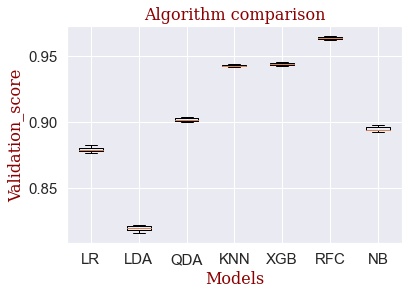

Wall time: 3min 21s


In [54]:
%%time
ensemble_models(Xtrain_ros_tf, ytrain_ros, Xtest_ros_tf, ytest_ros, target_names_ros)

###  After over sampling the data, Random Forest Classifier and XGBoost Classifier perfomed better compared to other model.

In [55]:
# Make prediction on validated dataset
RFC_model_ros = RandomForestClassifier(n_jobs=-1)
RFC_model_ros.fit(Xtrain_ros_tf, ytrain_ros)
RFC_prediction_ros = RFC_model_ros.predict(Xtest_ros_tf)

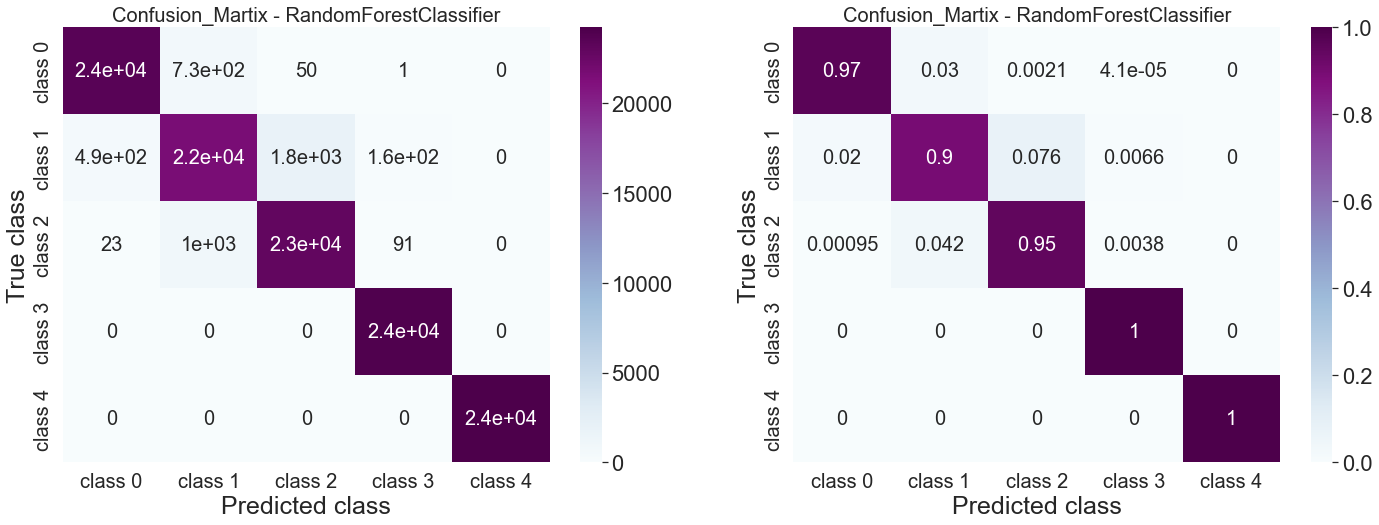

In [56]:
Confusion_Matrix_(ytest_ros, RFC_prediction_ros, target_names_ros ,'RandomForestClassifier')

In [57]:
# Make prediction on validated dataset
xgb_model_ros = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,eval_metric='mlogloss')#RandomForestClassifier(n_jobs=-1)
xgb_model_ros.fit(Xtrain_ros_tf, ytrain_ros)
xgb_prediction_ros = xgb_model_ros.predict(Xtest_ros_tf)

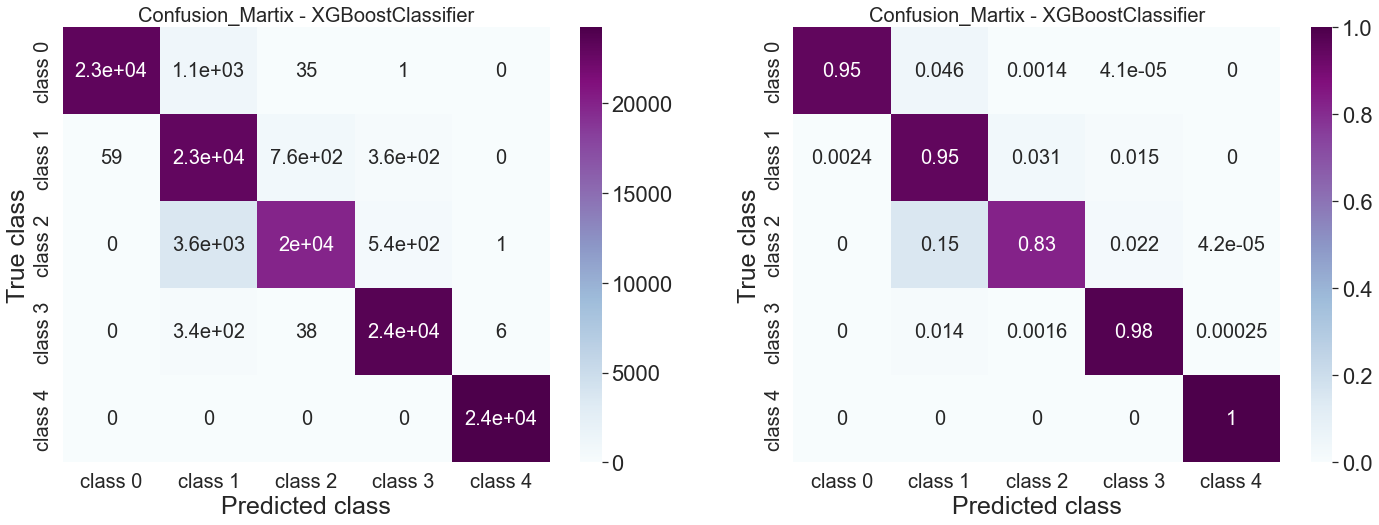

In [58]:
Confusion_Matrix_(ytest_ros, xgb_prediction_ros, target_names_ros ,'XGBoostClassifier')

### 8.2 calculating feature importance using RandomForestClassifier and XGBclassifier

<AxesSubplot:xlabel='importance', ylabel='feature'>

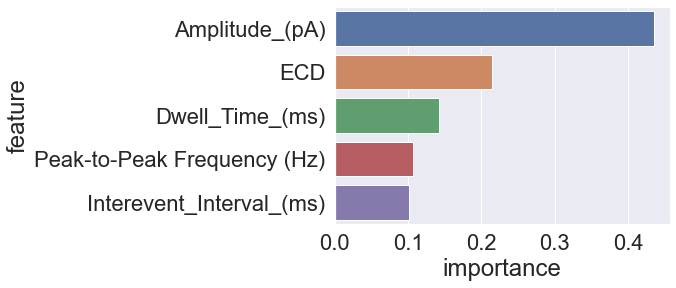

In [59]:
feature_importance_dict = {'importance': RFC_model_ros.feature_importances_, 'feature': Xtrain_ros_tf.columns}
importance = pd.DataFrame(data=feature_importance_dict).sort_values('importance', ascending=False)
sns.barplot(data= importance, x = 'importance', y = 'feature' )

<AxesSubplot:xlabel='importance', ylabel='feature'>

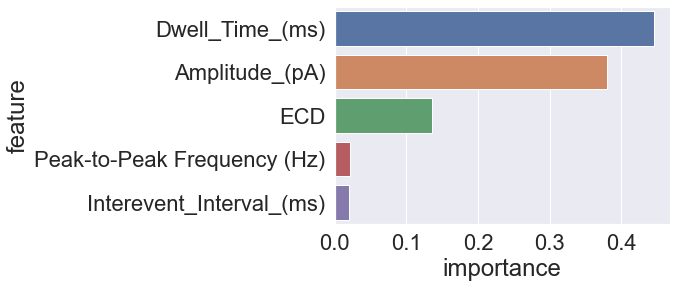

In [60]:
feature_importance_dict = {'importance': xgb_model_ros.feature_importances_, 'feature': Xtrain_ros_tf.columns}
importance = pd.DataFrame(data=feature_importance_dict).sort_values('importance', ascending=False)
sns.barplot(data= importance, x = 'importance', y = 'feature' )

#### The feature importance plot generated during model testing (XGBclassifier and RandomForestClassifier) indicates the relative relevance of all six features in event classification, and it appears that in XGBoost only 3 features out of 5 of them plays an essential role. So I'm going to re-run the model with those critical features.

# __________________________________________________________________

#### Using feature importance from XGBoost model as the model runs efficiently with just 3 features compare to RandomForestClassifier which shows importance of all the features and also with 3 features we gain in computational time.

In [61]:
# removing 'Peak-to-Peak Frequency (Hz)' and 'Interevent_Interval_(ms)' features from the dataframe
Xtrain_ros_tf = Xtrain_ros_tf.drop(labels= ['Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)'],axis=1)
Xtest_ros_tf = Xtest_ros_tf.drop(labels= ['Interevent_Interval_(ms)', 'Peak-to-Peak Frequency (Hz)'],axis=1)

##############################
LogisticRegression

              precision    recall  f1-score   support

     class 0       1.00      0.93      0.96     24319
     class 1       0.68      0.98      0.80     24105
     class 2       0.87      0.71      0.79     24087
     class 3       0.88      0.66      0.75     24025
     class 4       0.92      0.98      0.95     24231

    accuracy                           0.85    120767
   macro avg       0.87      0.85      0.85    120767
weighted avg       0.87      0.85      0.85    120767

##############################
LinearDiscriminantAnalysis

              precision    recall  f1-score   support

     class 0       1.00      0.78      0.88     24319
     class 1       0.67      0.66      0.66     24105
     class 2       0.65      0.89      0.75     24087
     class 3       0.86      0.84      0.85     24025
     class 4       0.99      0.89      0.94     24231

    accuracy                           0.81    120767
   macro avg       0.

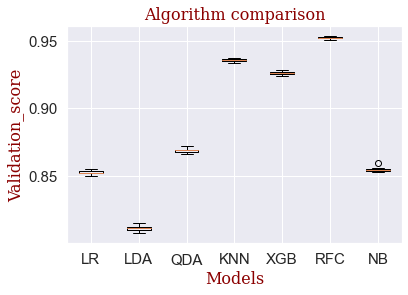

Wall time: 2min 15s


In [62]:
%%time
ensemble_models(Xtrain_ros_tf, ytrain_ros, Xtest_ros_tf, ytest_ros, target_names_ros)

#### Finally I choose to work with Random Forest Classifier and XGBoost Classifer. Now, the next step is to tune the hyper parameters for both model. Before tuning the hyperparameters it would be wise to check the training and testing score again individually:

In [63]:
%%time
RFCs = RandomForestClassifier(random_state=42, n_jobs=-1).fit(Xtrain_ros_tf,ytrain_ros)
print('\n')
print(f"""The train accuracy is: {round(RFCs.score(Xtrain_ros_tf, ytrain_ros),3)*100}%
The test accuracy is: {round(RFCs.score(Xtest_ros_tf,ytest_ros),3)*100}%""")
print('\n')

The train accuracy is: 99.9%
The test accuracy is: 95.3%
Wall time: 7.4 s


In [64]:
%%time
XGBc =xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False).fit(Xtrain_ros_tf,ytrain_ros)
print('\n')
print(f"""The train accuracy is: {round(XGBc.score(Xtrain_ros_tf, ytrain_ros),3)*100}%
The test accuracy is: {round(XGBc.score(Xtest_ros_tf,ytest_ros),3)*100}%""")
print('\n')

[18:30:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The train accuracy is: 92.60000000000001%
The test accuracy is: 92.5%


Wall time: 1.88 s


In [69]:
%%time
KNNc = KNeighborsClassifier(algorithm = 'kd_tree', n_jobs = -1).fit(Xtrain_ros_tf,ytrain_ros)
print('\n')
print(f"""The train accuracy is: {round(KNNc.score(Xtrain_ros_tf, ytrain_ros),3)*100}%
The test accuracy is: {round(KNNc.score(Xtest_ros_tf,ytest_ros),3)*100}%""")
print('\n')



The train accuracy is: 95.6%
The test accuracy is: 93.60000000000001%


Wall time: 8.49 s


### 8.3 Hyperparameter tuning

In [65]:
%%time
RFCs = RandomForestClassifier(random_state=42, n_jobs=-1)
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
clf_RFC = GridSearchCV(RFCs, {'max_depth': [ 10,25,50,100],
                                   'min_samples_split': [10, 25, 50, 100],
                                 'min_samples_leaf':[10,50,100]}, verbose=1, cv =kfold)

clf_RFC.fit(Xtrain_ros_tf, ytrain_ros)

#print(clf_RFC.best_score_)
print('\n')
print(f'Print Best Model Parameters:')
print('\n')

print(clf_RFC.best_params_)
#RandomForestClassifier().get_params().keys()

RFCs = RandomForestClassifier(max_depth= clf_RFC.best_params_['max_depth'], min_samples_split= clf_RFC.best_params_['min_samples_split'], min_samples_leaf=clf_RFC.best_params_['min_samples_leaf'],random_state=42, n_jobs=-1)
RFCs.fit(Xtrain_ros_tf, ytrain_ros)
ypred_RFC = RFCs.predict(Xtest_ros_tf)
print('\n')
print(f'Calculating Scores .......')
print('\n')
print(f'Scores:')
print()

print(f"""The train accuracy is: {round(RFCs.score(Xtrain_ros_tf, ytrain_ros),3)*100}%
The test accuracy is: {round(RFCs.score(Xtest_ros_tf,ytest_ros),3)*100}%""")
print('\n')
Confusion_Matrix_(ytest_ros, ypred_RFC, target_names_ros ,'RFClassifier')
print('\n')

Fitting 10 folds for each of 48 candidates, totalling 480 fits
Print Best Model Parameters:


{'max_depth': 50, 'min_samples_leaf': 10, 'min_samples_split': 10}
Calculating Scores .......


Scores:

The train accuracy is: 94.6%
The test accuracy is: 93.7%
Wall time: 39min 48s


In [68]:
%%time
XGB = xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False)
params = {
        'n_estimators':[10, 20],
        'learning_rate': [0.01, 0.1],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1],
        'subsample': [0.6, 0.8],
        'colsample_bytree': [0.6, 0.8],
        'max_depth': [5,7],
        'eval_metric':['mlogloss'],
        'reg_lambda':[0.1, 0.2]
        }
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
clf_XGB = GridSearchCV(XGB, params, cv =kfold )
clf_XGB.fit(Xtrain_ros_tf, ytrain_ros)
ypred_XGB = RFCs.predict(Xtest_ros_tf)
print(f'Print Best Model Parameters:')
print('\n')

print(clf_XGB.best_params_)


XGBc =xgb.dask.XGBClassifier(tree_method = 'gpu_hist',verbosity=1,use_label_encoder=False,
    n_estimators = clf_XGB.best_params_['n_estimators'],
    learning_rate = clf_XGB.best_params_['learning_rate'],
    min_child_weight= clf_XGB.best_params_['min_child_weight'], 
    gamma= clf_XGB.best_params_['gamma'], 
    subsample=clf_XGB.best_params_['subsample'],
    colsample_bytree = clf_XGB.best_params_['colsample_bytree'],
    max_depth = clf_XGB.best_params_['max_depth'],
    eval_metric = clf_XGB.best_params_['eval_metric'],
    reg_lambda = clf_XGB.best_params_['reg_lambda'],
    random_state=42)

XGBc.fit(Xtrain_ros_tf, ytrain_ros)
print(f'Calculating Scores .......')
print('\n')
print(f'Scores:')
print()
print(f"""The train accuracy is: {round(XGBc.score(Xtrain_ros_tf, ytrain_ros),3)*100}%
The test accuracy is: {round(XGBc.score(Xtest_ros_tf,ytest_ros),3)*100}%""")
print('\n')
Confusion_Matrix_(ytest_ros, ypred_XGB, target_names_ros ,'RFClassifier')
print('\n')

Print Best Model Parameters:


{'colsample_bytree': 0.8, 'eval_metric': 'mlogloss', 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 20, 'reg_lambda': 0.1, 'subsample': 0.6}
Calculating Scores .......


Scores:

The train accuracy is: 92.5%
The test accuracy is: 92.4%


Wall time: 25min 26s




Print Best Model Parameters:


{'leaf_size': 20, 'n_neighbors': 10}


Calculating Scores .......


Scores:

The train accuracy is: 94.39999999999999%
The test accuracy is: 93.5%




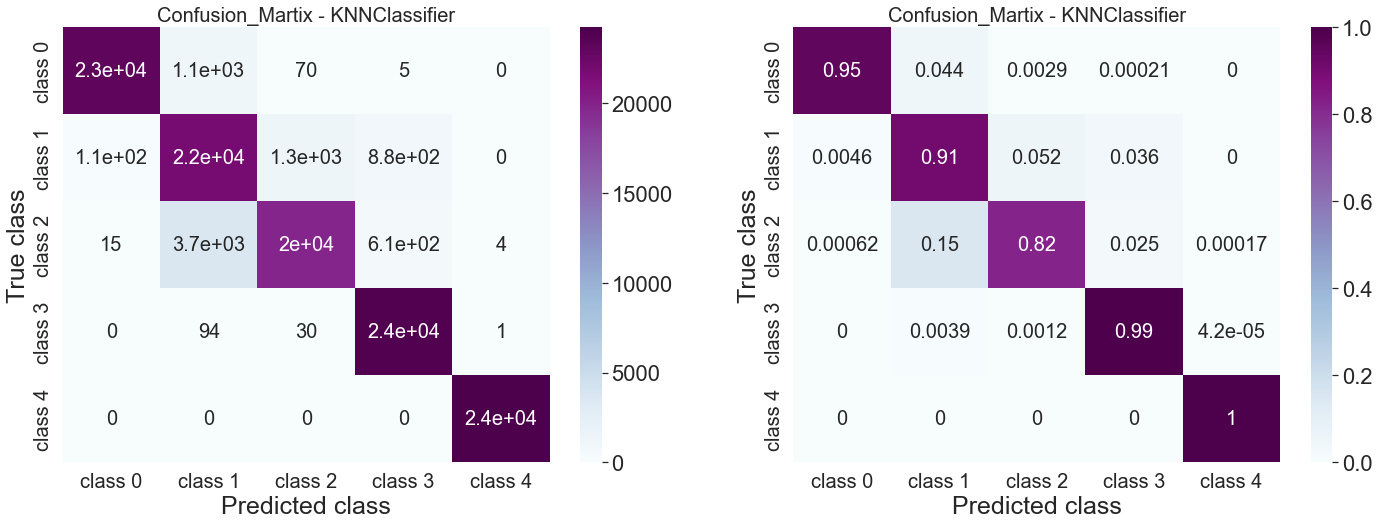



Wall time: 3min 36s


In [81]:
%%time
KNNc = KNeighborsClassifier(algorithm = 'kd_tree', n_jobs = -1)
kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
clf_KNNc = GridSearchCV(KNNc, {'n_neighbors': [ 10,25,50,100],
                               'leaf_size': [10,20,30,50,100]},cv =  kfold)

clf_KNNc.fit(Xtrain_ros_tf, ytrain_ros)

#print(clf_KNNc.best_score_)
print('\n')
print(f'Print Best Model Parameters:')
print('\n')

print(clf_KNNc.best_params_)


KNNc = KNeighborsClassifier(n_neighbors= clf_KNNc.best_params_['n_neighbors'],
                            leaf_size = clf_KNNc.best_params_['leaf_size'], 
                             
                            n_jobs=-1)
KNNc.fit(Xtrain_ros_tf, ytrain_ros)
ypred_KNN = KNNc.predict(Xtest_ros_tf)
print('\n')
print(f'Calculating Scores .......')
print('\n')
print(f'Scores:')
print()

print(f"""The train accuracy is: {round(KNNc.score(Xtrain_ros_tf, ytrain_ros),3)*100}%
The test accuracy is: {round(KNNc.score(Xtest_ros_tf,ytest_ros),3)*100}%""")
print('\n')
Confusion_Matrix_(ytest_ros, ypred_KNN, target_names_ros ,'KNNClassifier')
print('\n')

#### 1.A custom made Machine Learning algo is developed to classify events which can perform with a general accuracy of ~ 93%.
#### 2.Here the aim was to build an algorithms which learn from the input data and demonstrate generality suitable for analysing naopore sensing data. 
#### 3.Event characterisation of the molecule demonstrates high consistency when probed with bioporin  and such data is well suited for developing a Machine Learning algo which can automatically recognize different type of molecule folding features.   